Get an archival data from the specified location

In [ ]:
# get_open_meteo_archive.py
"""
Fetch hourly archival weather variables from Open-Meteo and return a pandas DataFrame.

Dependencies:
  pip install requests pandas

Function:
  get_open_meteo_archive(lat, lon, start_date, end_date, timezone='UTC')

Inputs:
  - lat: float latitude
  - lon: float longitude
  - start_date: str 'YYYY-MM-DD'
  - end_date: str   'YYYY-MM-DD'
  - timezone: optional timezone string to request (default 'UTC')

Returns:
  pandas.DataFrame indexed by UTC datetime with columns:
    temperature_2m,
    surface_pressure,
    solar_radiation,
    windspeed_10m,
    windspeed_100m,
    winddirection_10m,
    winddirection_100m,
    windgusts_10m,
    relativehumidity_2m,
    sunshine_duration,
    ghi,
    dni,
    dhi,
    gti,
    clouds_high,
    clouds_mid,
    clouds_low,
    clouds_total

Notes:
  - The Open-Meteo archive API may limit the maximum span per request. This function will chunk requests in 31-day windows.
  - Some variables may not exist for all regions or API configurations. Missing variables will be NaN.
  - If you want GTI computed for a surface tilt/azimuth, additional parameters might be required by the API; adjust accordingly.
"""

from datetime import datetime, timedelta
from typing import List, Dict, Any
import requests
import pandas as pd
import math

OPEN_METEO_ARCHIVE_ENDPOINT = "https://archive-api.open-meteo.com/v1/archive"

# Mapping of output column names -> possible Open-Meteo hourly variable names (aliases)
_OUTPUT_VAR_ALIASES: Dict[str, List[str]] = {
    "temperature_2m": ["temperature_2m"],
    "surface_pressure": ["surface_pressure"],
    # general solar / shortwave aliases
    "solar_radiation": ["shortwave_radiation", "surface_solar_radiation_downwards"],
    "windspeed_10m": ["windspeed_10m"],
    "windspeed_100m": ["windspeed_100m"],
    "winddirection_10m": ["winddirection_10m"],
    "winddirection_100m": ["winddirection_100m"],
    "windgusts_10m": ["windgusts_10m"],
    "relativehumidity_2m": ["relativehumidity_2m"],
    "sunshine_duration": ["sunshine_duration"],
    # Irradiance variables: GHI / DNI / DHI common names
    "ghi": ["ghi", "surface_solar_radiation_downwards", "shortwave_radiation"],
    "dni": ["dni", "direct_normal_irradiance", "direct_radiation"],
    "dhi": ["dhi", "diffuse_radiation"],
    # GTI (global tilted irradiance) aliases - may require tilt params on some endpoints
    "gti": ["gti", "global_tilted_irradiance"],
    # Clouds
    "clouds_high": ["cloudcover_high", "high_clouds", "clouds_high"],
    "clouds_mid": ["cloudcover_mid", "mid_clouds", "clouds_mid"],
    "clouds_low": ["cloudcover_low", "low_clouds", "clouds_low"],
    "clouds_total": ["cloudcover", "clouds", "total_clouds"],
}

def _chunk_date_ranges(start_date: datetime, end_date: datetime, max_days: int = 31):
    """
    Yield (chunk_start_date, chunk_end_date) tuples inclusive, each range <= max_days.
    """
    cur = start_date
    while cur <= end_date:
        chunk_end = min(end_date, cur + timedelta(days=max_days - 1))
        yield cur.date().isoformat(), chunk_end.date().isoformat()
        cur = chunk_end + timedelta(days=1)

def _collect_hourly_variable_list() -> List[str]:
    """Return a deduplicated list of preferred alias names to request from the API.
    Prefer the first alias for each output variable and remove duplicates preserving order.
    """
    vars_pref: List[str] = []
    for aliases in _OUTPUT_VAR_ALIASES.values():
        if not aliases:
            continue
        primary = aliases[0]
        if primary not in vars_pref:
            vars_pref.append(primary)
    return vars_pref

def get_open_meteo_archive(lat: float, lon: float, start_date: str, end_date: str, timezone: str = "UTC") -> pd.DataFrame:
    """
    Fetch hourly archival data from Open-Meteo and return a pandas DataFrame.

    Parameters:
      lat (float): latitude
      lon (float): longitude
      start_date (str): 'YYYY-MM-DD'
      end_date (str): 'YYYY-MM-DD'
      timezone (str): timezone for returned timestamps (default 'UTC')

    Returns:
      pandas.DataFrame indexed by DatetimeIndex (UTC) with the output columns specified in the module docstring.
    """
    # Validate dates
    try:
        dt_start = datetime.strptime(start_date, "%Y-%m-%d")
        dt_end = datetime.strptime(end_date, "%Y-%m-%d")
    except ValueError:
        raise ValueError("start_date and end_date must be in YYYY-MM-DD format")
    if dt_end < dt_start:
        raise ValueError("end_date must be >= start_date")

    hourly_vars = _collect_hourly_variable_list()
    hourly_param = ",".join(hourly_vars)

    frames: List[pd.DataFrame] = []

    for chunk_start, chunk_end in _chunk_date_ranges(dt_start, dt_end, max_days=31):
        params = {
            "latitude": lat,
            "longitude": lon,
            "start_date": chunk_start,
            "end_date": chunk_end,
            "hourly": hourly_param,
            "timezone": timezone
        }
        resp = requests.get(OPEN_METEO_ARCHIVE_ENDPOINT, params=params, timeout=30)
        if resp.status_code != 200:
            raise RuntimeError(f"Open-Meteo API error {resp.status_code}: {resp.text}")

        j = resp.json()
        if "hourly" not in j or "time" not in j["hourly"]:
            # If the API returns no hourly data for this chunk, skip
            continue

        hourly = j["hourly"]
        time_vals = hourly.get("time", [])
        if len(time_vals) == 0:
            continue

        df_chunk = pd.DataFrame(index=pd.to_datetime(time_vals))
        # Ensure index has timezone if requested; pandas will keep tz-aware string parse; we'll normalize to UTC at the end
        for out_col, aliases in _OUTPUT_VAR_ALIASES.items():
            # find the first alias that exists in response hourly keys
            found_series = None
            for alias in aliases:
                if alias in hourly:
                    found_series = hourly[alias]
                    break
            if found_series is not None:
                # Ensure same length as time, or pad/trim accordingly
                series = pd.Series(found_series, index=pd.to_datetime(time_vals))
                series.name = out_col
                df_chunk[out_col] = series
            else:
                # Variable not present in this API response; create NaN series
                df_chunk[out_col] = pd.Series([float("nan")] * len(time_vals), index=pd.to_datetime(time_vals))

        frames.append(df_chunk)

    if not frames:
        # no data returned
        # return empty dataframe with requested columns and index empty
        empty_idx = pd.DatetimeIndex([], dtype="datetime64[ns, UTC]")
        empty_df = pd.DataFrame(index=empty_idx, columns=list(_OUTPUT_VAR_ALIASES.keys()))
        return empty_df

    # concat and deduplicate index
    df_all = pd.concat(frames)
    # Convert index to timezone-aware UTC if not already
    try:
        # If strings included timezone info, pandas might already have tz; otherwise set tz to provided timezone and convert to UTC.
        if df_all.index.tz is None:
            # assume they were requested in 'timezone' string; localize then convert to UTC
            # if timezone was 'UTC', this will set tzinfo correctly
            df_all.index = df_all.index.tz_localize(timezone).tz_convert("UTC")
        else:
            df_all.index = df_all.index.tz_convert("UTC")
        # finally remove tz info (or keep tz-aware index — here we keep tz-aware)
    except Exception:
        # fallback: parse naive to UTC
        df_all.index = pd.to_datetime(df_all.index, utc=True)

    # sort and drop duplicates keeping first
    df_all = df_all.sort_index().loc[~df_all.index.duplicated(keep="first")]

    # Re-order columns deterministically
    ordered_cols = list(_OUTPUT_VAR_ALIASES.keys())
    for c in ordered_cols:
        if c not in df_all.columns:
            df_all[c] = float("nan")
    df_all = df_all[ordered_cols]

    # Reset name of index
    df_all.index.name = "time_utc"

    return df_all

# take input data from csv "input_for_weather_archive_download.csv" file with columns: name_of_site, latitude, longitude, start_date, end_date 
# and download weather data for each site and save every site data to separate csv file named "<name_of_site>_weather_data.csv" in folder "weather_data_downloaded/"
if __name__ == "__main__":
    input_df = pd.read_csv("input_for_weather_archive_download.csv")
    for idx, row in input_df.iterrows():
        site_name = row['name_of_site']
        lat = float(row['latitude'])
        lon = float(row['longitude'])
        start_date = row['start_date']
        end_date = row['end_date']
        
        print(f"Downloading data for site: {site_name} ({lat}, {lon}) from {start_date} to {end_date}")
        weather_df = get_open_meteo_archive(lat, lon, start_date, end_date)
        
        output_filename = f"weather_data_downloaded/{site_name}_weather_data.csv"
        weather_df.to_csv(output_filename)
        print(f"Saved data to {output_filename}")

23-01-01


RuntimeError: Open-Meteo API error 400: {"error":true,"reason":"Data corrupted at path ''. Cannot initialize SurfacePressureAndHeightVariable<VariableAndPreviousDay, ForecastPressureVariable, ForecastHeightVariable> from invalid String value temperature_2m,surface_pressure,shortwave_radiation,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m,relativehumidity_2m,sunshine_duration,ghi,dni,dhi,gti,cloudcover_high,cloudcover_mid,cloudcover_low,cloudcover."}

In [ ]:
Code for the download of archival wind turbine efficiency data 

In [ ]:
import requests
import pandas as pd
import urllib.parse
import time

API_KEY = "{{YOUR_API_KEY}}"
EMAIL = "karolinabudrewicz2003@gmail.com"
BASE_URL = "https://developer.nrel.gov/api/nsrdb/v2/solar/himawari-download.json?"
POINTS = [
'1281027'
]

def main():
    input_data = {
        'attributes': 'cloud_type,wind_direction,wind_speed,relative_humidity,air_temperature,surface_pressure,surface_albedo',
        'interval': '30',
        
        'api_key': API_KEY,
        'email': EMAIL,
    }
    for name in ['2020']:
        print(f"Processing name: {name}")
        for id, location_ids in enumerate(POINTS):
            input_data['names'] = [name]
            input_data['location_ids'] = location_ids
            print(f'Making request for point group {id + 1} of {len(POINTS)}...')

            if '.csv' in BASE_URL:
                url = BASE_URL + urllib.parse.urlencode(data, True)
                # Note: CSV format is only supported for single point requests
                # Suggest that you might append to a larger data frame
                data = pd.read_csv(url)
                print(f'Response data (you should replace this print statement with your processing): {data}')
                # You can use the following code to write it to a file
                # data.to_csv('SingleBigDataPoint.csv')
            else:
                headers = {
                  'x-api-key': API_KEY
                }
                data = get_response_json_and_handle_errors(requests.post(BASE_URL, input_data, headers=headers))
                download_url = data['outputs']['downloadUrl']
                # You can do with what you will the download url
                print(data['outputs']['message'])
                print(f"Data can be downloaded from this url when ready: {download_url}")

                # Delay for 1 second to prevent rate limiting
                time.sleep(1)
            print(f'Processed')


def get_response_json_and_handle_errors(response: requests.Response) -> dict:
    """Takes the given response and handles any errors, along with providing
    the resulting json

    Parameters
    ----------
    response : requests.Response
        The response object

    Returns
    -------
    dict
        The resulting json
    """
    if response.status_code != 200:
        print(f"An error has occurred with the server or the request. The request response code/status: {response.status_code} {response.reason}")
        print(f"The response body: {response.text}")
        exit(1)

    try:
        response_json = response.json()
    except:
        print(f"The response couldn't be parsed as JSON, likely an issue with the server, here is the text: {response.text}")
        exit(1)

    if len(response_json['errors']) > 0:
        errors = '\n'.join(response_json['errors'])
        print(f"The request errored out, here are the errors: {errors}")
        exit(1)
    return response_json

if __name__ == "__main__":
    main()

Clearing the dataset in csv file for the solar panels efficiency 

In [ ]:
# open result.csv file and filter rows where PVDAQPVTechnology is in ALLOWED_TECH and PVDAQArray Configuration is in ALLOWED_CONFIG
import pandas as pd


print("Starting filtering process...")
ALLOWED_TECH = [
    "Mono-si"
    ]

ALLOWED_CONFIG = [
    "Fixed roof",
    "Fixed ground",
]

TECH_COL = "PVDAQPVTechnology"
CFG_COL = "PVDAQArray Configuration"

def main():
    df = pd.read_csv("result.csv", sep=";")
    df.columns = df.columns.str.strip()

    df[TECH_COL] = df[TECH_COL].fillna("").str.strip()
    df[CFG_COL] = df[CFG_COL].fillna("").str.strip()

    tech_norm = df[TECH_COL].str.casefold()
    cfg_norm = df[CFG_COL].str.casefold()

    allowed_tech = {x.casefold() for x in ALLOWED_TECH}
    allowed_cfg = {x.casefold() for x in ALLOWED_CONFIG}

    mask = tech_norm.isin(allowed_tech) & cfg_norm.isin(allowed_cfg)
    filtered = df.loc[mask]
    if filtered.empty:
        print("error lol")
        raise ValueError("No rows matched the filters.")

    print(df)
    filtered.to_csv("results_cleared.csv", sep=";", index=False)
if __name__ == "__main__":
    main()


Starting filtering process...
xd
                                    system_public_name   System public name  \
0    PVDAQ/Sites/ Distributed Sun - 6 Executive Cam...                        
1    PVDAQ/Sites/ Distributed Sun - BWI Hilton     ...                        
2    PVDAQ/Sites/ Distributed Sun - EJ DeSeta      ...                        
3    PVDAQ/Sites/ Distributed Sun - The Wharf      ...                        
4    PVDAQ/Sites/ FSEC - Zero Energy House - Liverm...                        
..                                                 ...                  ...   
995  PVDAQ/Sites/Pvoutput.org Lawrence Drive       ...                        
996  PVDAQ/Sites/Pvoutput.org Leaf Rider           ...                        
997  PVDAQ/Sites/Pvoutput.org Lebo Residence       ...                        
998  PVDAQ/Sites/Pvoutput.org Lee Morehead Denton T...                        
999  PVDAQ/Sites/Pvoutput.org Lehman P - San Franci...                        

      PVDAQSystemS

data downloader

In [20]:
# the objective of this script is to read a csv file "results_cleared.csv" with column "system_public_name"
# for each value in this column, go to the website "https://openei.org/wiki/PVDAQ/Sites/<system_public_name>"
# and scrape the following data using the provided XPATHS:
# location_exact, coordinates, system_id, first_timestamp, last_timestamp
# then add these data as new columns to the dataframe and save it back to "results_cleared.csv"
# using requests and urllib

XPATHS = {
    "location_exact": "/html/body/div[2]/div[1]/div[4]/div[2]/div/div[3]/div[1]/div[2]/div[2]/div/div/div[4]/div/span",
    "coordinates": "/html/body/div[2]/div[1]/div[4]/div[2]/div/div[3]/div[1]/div[2]/div[2]/div/div/div[7]/div/span",
    "system_id": "/html/body/div[2]/div[1]/div[4]/div[2]/div/div[3]/div[1]/div[2]/div[2]/div/div/div[2]/div/span",
    "first_timestamp": "/html/body/div[2]/div[1]/div[4]/div[2]/div/div[3]/div[1]/div[2]/div[2]/div/div/div[12]",
    "last_timestamp": "/html/body/div[2]/div[1]/div[4]/div[2]/div/div[3]/div[1]/div[2]/div[2]/div/div/div[13]/div/span",
}

import time
import pandas as pd
import requests
import urllib

def get_public_names():
    df = pd.read_csv("results_cleared.csv", sep=";")
    df.columns = df.columns.str.strip()
    public_names = df["system_public_name"].tolist()
    return public_names

def scrape_data(system_public_name):
    system_public_name_corrected = system_public_name.replace(" ", "_")
    # remove all the "_" at the end of the string
    while system_public_name_corrected.endswith("_"):
        system_public_name_corrected = system_public_name_corrected[:-1]
    url = f"https://openei.org/wiki/{system_public_name_corrected}"
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Failed to retrieve data for {system_public_name}")
        print(url)
        return None

    from lxml import html
    tree = html.fromstring(response.content)

    data = {}
    for key, xpath in XPATHS.items():
        element = tree.xpath(xpath)
        if element:
            data[key] = element[0].text_content().strip()
        else:
            data[key] = None
    return data

def main():
    df = pd.read_csv("results_cleared.csv", sep=";")
    df.columns = df.columns.str.strip()
    print(df.columns)
    public_names = df["system_public_name"].tolist()

    scraped_data = []
    for name in public_names:
        print(f"Scraping data for {name}...")
        data = scrape_data(name)
        if data:
            scraped_data.append(data)
        else:
            scraped_data.append({key: None for key in XPATHS.keys()})
        time.sleep(1)  # be polite and avoid hammering the server

    scraped_df = pd.DataFrame(scraped_data)
    result_df = pd.concat([df.reset_index(drop=True), scraped_df], axis=1)

    # in column first_timestamp many rows look like this "First Timestamp 2011-08-30 23:00:00" so in other rows than first which is containg a column name, remove this "First Timestamp " part
    result_df['first_timestamp'] = result_df['first_timestamp'].str.replace('First Timestamp ', '', regex=False)
    result_df.to_csv("results_cleared_enriched.csv", sep=";", index=False)

if __name__ == "__main__":
    main()

Index(['system_public_name', 'System public name', 'PVDAQSystemSize',
       'PVDAQPVTechnology', 'PVDAQKGClimateZone', 'PVDAQArray Configuration',
       'PVDAQfirst timestamp', 'PVDAQlast timestamp', 'PVDAQYearsofData',
       'PVDAQState', 'PVDAQMin Temporal Resolution', 'PVDAQNumber Channels',
       'PVDAQDataset Size'],
      dtype='object')
Scraping data for PVDAQ/Sites/Andre Agassi Preparatory Academy - Building B                              ...
Scraping data for PVDAQ/Sites/Andre Agassi Preparatory Academy - Building C                              ...
Scraping data for PVDAQ/Sites/Andre Agassi Preparatory Academy - Building D                              ...
Scraping data for PVDAQ/Sites/Commercial - NOLA                                                          ...
Scraping data for PVDAQ/Sites/FSEC - Zero Energy House - Lakeland                                        ...
Scraping data for PVDAQ/Sites/Farm Solar Array                                                           

REMOVE UNWANTED ROWS

In [22]:
# open results_cleared_enriched.csv and remove rows where the name is stated here on a list

import pandas as pd

NAMES_TO_REMOVE = [
    "PVDAQ/Sites/Maui Ocean Center",
    "PVDAQ/Sites/Mercury Solar Systems - Array 4",
    "PVDAQ/Sites/Mercury Solar Systems - Array 5",
    "PVDAQ/Sites/Commercial - NOLA",
    "PVDAQ/Sites/Farm Solar Array",
]

df = pd.read_csv("results_cleared_enriched.csv", sep=";")
df.columns = df.columns.str.strip()
df = df[~df["system_public_name"].isin(NAMES_TO_REMOVE)]
df.to_csv("results_cleared_enriched_filtered.csv", sep=";", index=False)

Code in order to download all the file with the efficiency data 

In [1]:

import xml.etree.ElementTree as ET
from pathlib import Path
from typing import Iterable, List
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import pandas as pd
import requests

#print all the heads visible in the csv file
import pandas as pd
df = pd.read_csv("results_cleared_enriched_filtered.csv", sep=";")
print(df.head())

S3_ENDPOINT = "https://oedi-data-lake.s3.amazonaws.com"
BASE_PREFIX = "pvdaq/csv/pvdata"
CSV_SOURCE = Path("results_cleared_enriched_filtered.csv")
OUTPUT_ROOT = Path(r"C:\Users\karol\OneDrive\Pulpit\Inzynierka\Program_renewable_energy\Solar_data_efficiency")
REQUEST_TIMEOUT = 30
SESSION = requests.Session()
RETRY_STRATEGY = Retry(
    total=5,
    backoff_factor=2,
    status_forcelist=[429, 500, 502, 503, 504],
    allowed_methods=["GET"]
)
SESSION.mount("https://", HTTPAdapter(max_retries=RETRY_STRATEGY))
CHUNK_SIZE = 1 << 15  # 32 KiB
NAMESPACE = {"s3": "http://s3.amazonaws.com/doc/2006-03-01/"}


def load_system_ids(csv_path: Path) -> List[str]:
    df = pd.read_csv(csv_path, sep=";")
  
    ids = (
        df[" system_id"]
        .dropna()
        .astype(str)
        .str.strip()
        .replace({"": None})
        .dropna()
        .unique()
        .tolist()
    )
    if not ids:
        raise ValueError("No system IDs found in results_cleared_enriched_filtered.csv")
    return ids


def list_system_keys(system_id: str) -> Iterable[str]:
    prefix = f"{BASE_PREFIX}/system_id={system_id}/"
    continuation = None
    while True:
        params = {"list-type": "2", "prefix": prefix}
        if continuation:
            params["continuation-token"] = continuation
        resp = SESSION.get(S3_ENDPOINT, params=params, timeout=REQUEST_TIMEOUT)
        resp.raise_for_status()
        root = ET.fromstring(resp.content)
        for contents in root.findall("s3:Contents", NAMESPACE):
            key = contents.findtext("s3:Key", default="", namespaces=NAMESPACE)
            if key.endswith(".csv"):
                yield key
        continuation = root.findtext("s3:NextContinuationToken", default="", namespaces=NAMESPACE)
        if not continuation:
            break


def download_file(key: str, dest: Path) -> None:
    dest.parent.mkdir(parents=True, exist_ok=True)
    if dest.exists():
        return
    url = f"{S3_ENDPOINT}/{requests.utils.quote(key, safe='/')}"
    print(url)
    with requests.get(url, stream=True, timeout=REQUEST_TIMEOUT) as resp:
        resp.raise_for_status()
        with dest.open("wb") as fh:
            for chunk in resp.iter_content(chunk_size=CHUNK_SIZE):
                if chunk:
                    fh.write(chunk)


def main() -> None:
    system_ids = load_system_ids(CSV_SOURCE)
    OUTPUT_ROOT.mkdir(parents=True, exist_ok=True)

    for system_id in system_ids:
        print(f"Listing files for system {system_id}...")
        base_path = OUTPUT_ROOT / f"system_{system_id}"
        for key in list_system_keys(system_id):
            relative = key.split(f"system_id={system_id}/", 1)[-1]
            dest_path = base_path / relative
            print(f"  Downloading {relative}")
            download_file(key, dest_path)
        print(f"Completed system {system_id}")

    print("All downloads finished.")


if __name__ == "__main__":
    main()





  system_public_name                                         \
0  PVDAQ/Sites/Andre Agassi Preparatory Academy -...          
1  PVDAQ/Sites/Andre Agassi Preparatory Academy -...          
2  PVDAQ/Sites/Andre Agassi Preparatory Academy -...          
3  PVDAQ/Sites/FSEC - Zero Energy House - Lakelan...          
4  PVDAQ/Sites/NREL Research Support Facility II ...          

    System public name   PVDAQSystemSize   PVDAQPVTechnology  \
0                        68.48             Mono-Si             
1                        40.56             Mono-Si             
2                        171.36            Mono-Si             
3                                 04.maj   Mono-Si             
4                        408.24            Mono-Si             

    PVDAQKGClimateZone   PVDAQArray Configuration   PVDAQfirst timestamp  \
0                        Fixed Roof                 30.08.2011 23:00       
1                        Fixed Roof                 30.08.2011 23:00       
2       

CLEANING MEXICO - NIZANDA FILE

In [ ]:
# Encoding-diagnose-and-read for Nizanda_database.csv
# Put this in a new notebook cell and run.
import io
import sys
from pathlib import Path

csv_path = Path("Nizanda_database.csv")
if not csv_path.exists():
    raise FileNotFoundError(f"{csv_path} not found in working dir: {Path.cwd()}")

# Try using charset-normalizer, then chardet (if installed)
detected = None
try:
    from charset_normalizer import from_bytes
    with csv_path.open("rb") as f:
        raw = f.read(65536)  # read first chunk
    results = from_bytes(raw)
    if results:
        best = results.best()
        if best:
            detected = {"encoding": best.encoding, "confidence": best.fingerprint or None}
            print("charset-normalizer detected:", detected)
except Exception:
    # charset_normalizer not available or failed; try chardet if present
    try:
        import chardet
        with csv_path.open("rb") as f:
            raw = f.read(65536)
        r = chardet.detect(raw)
        detected = {"encoding": r.get("encoding"), "confidence": r.get("confidence")}
        print("chardet detected:", detected)
    except Exception:
        print("No charset detector available (charset-normalizer/chardet). We'll try common encodings directly.")

import pandas as pd

# list of encodings to try, ordered
encodings_to_try = []
if detected and detected.get("encoding"):
    encodings_to_try.append(detected["encoding"])
encodings_to_try += ["utf-8-sig", "utf-8", "cp1252", "latin-1", "iso-8859-1"]

# keep track of last exception
last_exc = None
df = None
for enc in encodings_to_try:
    try:
        print(f"Trying encoding: {enc!r} ...", end=" ")
        df = pd.read_csv(csv_path, encoding=enc, sep=None, engine="python", nrows=5)
        print("OK")
        used_encoding = enc
        break
    except Exception as e:
        last_exc = e
        print("failed:", type(e).__name__, "-", e)

if df is None:
    # Last-resort read with permissive settings
    try:
        print("Attempting permissive read with errors='replace' and encoding='latin-1' ...")
        df = pd.read_csv(csv_path, encoding="latin-1", engine="python", error_bad_lines=False, warn_bad_lines=True)
        used_encoding = "latin-1 (permissive)"
        print("Permissive read succeeded (data may contain replaced chars).")
    except Exception as e:
        print("All attempts failed. Last exception:", last_exc)
        raise

#print(f"\nRead succeeded using encoding: {used_encoding!r}")
#print("Preview:")
#print(df.head())

# Optionally save a UTF-8 normalized copy for future use
out_path = csv_path.with_name(csv_path.stem + "_utf8.csv")
try:
    # Re-read full file with the working encoding to save complete dataframe
    full_df = pd.read_csv(csv_path, sep=",", encoding=used_encoding.split(" ")[0], engine="python")
    full_df.to_csv(out_path, index=False, encoding="utf-8")
    print(f"Saved UTF-8 normalized copy to: {out_path}")
except Exception as e:
    print("Could not save UTF-8 copy (some encodings may not be re-used exactly):", e)

#delete this columns: Segment,	Source,	Barometer - mm Hg,	High Temp - °C,	Low Temp - °C,	Dew Point - °C	Wet Bulb - °C,	Wind Direction,	Wind Run - m,	High Wind Speed - m/s,	High Wind Direction, Wind Chill - °C,	Heat Index - °C,	THW Index - °C,	Rain - mm,	Rain Rate - mm/h, ET - mm,	Heating Degree Days,	Cooling Degree Days,	InTemp,	InHum,	In Dew,	InHeat,	InEMC,	In AirDensity,	WindSamp,	WindTx, 	ISSRecept,	Arc.Int.,	HiSolarRad
columns_to_delete = ['Segment',	'Source',	'Barometer - mm Hg',	'High Temp - °C',	'Low Temp - °C',	'Dew Point - °C',	'Wet Bulb - °C',	'Wind Direction',	'Wind Run - m',	'High Wind Speed - m/s',	'High Wind Direction', 'Wind Chill - °C',	'Heat Index - °C',	'THW Index - °C',	'Rain - mm',	'Rain Rate - mm/h', 'ET - mm',	'Heating Degree Days',	'Cooling Degree Days',	'InTemp',	'InHum',	'In Dew',	'InHeat',	'InEMC', 'In AirDensity', 'WindSamp', 	'WindTx',  'ISSRecept',	'Arc.Int.',	'HiSolarRad']
df = df.drop(columns=columns_to_delete, errors='ignore')
print(df.head())


charset-normalizer detected: {'encoding': 'cp1250', 'confidence': '57d2f7dc1281a89464c5cd426f52bb25e8fdd81e41782507796c59982d0f9b2d'}
Trying encoding: 'cp1250' ... OK
Could not save UTF-8 copy (some encodings may not be re-used exactly): Expected 12 fields in line 4, saw 17
   Day  Month  Year  Hour  Minute Temp - °C  Hum - % Wind Speed - m/s  \
0    5      2  2006    19       0      24,3     49.0                0   
1    5      2  2006    20      11       NaN      NaN              NaN   
2    6      2  2006    23       0      29,4     37.0              1,3   
3    6      2  2006    23      30      30,4     33.0              1,8   
4    7      2  2006     0       0      31,1     33.0              1,3   

   WindTx   SolarRad SolarEnergy  
0        1       0.0           0  
1        1       NaN         NaN  
2        1     799.0       34,36  
3        1     853.0       36,68  
4        1     889.0       38,23  
Could not save UTF-8 copy (some encodings may not be re-used exactly): Expec

CLEANING IRAN

In [58]:
#read csv file qzvin_hourly_data.csv and print its columns
import pandas as pd
df = pd.read_csv("qzvin_hourly_data.csv")


#delete the following columns: 'dew_point_2m', 'apparent_temperature', 'precipitation', 'rain', 'snowfall', 'snow_depth', 'weather_code', 'pressure_msl', 'surface_pressure', 'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high','et0_fao_evapotranspiration', 'vapour_pressure_deficit', 'wind_direction_10m', 'wind_direction_100m', 'wind_gusts_10m', 'soil_temperature_0_to_7cm', 'soil_temperature_7_to_28cm', 'soil_temperature_28_to_100cm','soil_temperature_100_to_255cm', 'soil_moisture_0_to_7cm', 'soil_moisture_7_to_28cm', 'soil_moisture_28_to_100cm', 'soil_moisture_100_to_255cm', 'shortwave_radiation', 'diffuse_radiation', 'global_tilted_irradiance', 'terrestrial_radiation',  'shortwave_radiation_instant', 'diffuse_radiation_instant', 'direct_normal_irradiance_instant', 'global_tilted_irradiance_instant', 'terrestrial_radiation_instant'
columns_to_delete = ['dew_point_2m', 'apparent_temperature', 'precipitation', 'rain', 'snowfall', 'snow_depth', 'weather_code', 'pressure_msl', 'surface_pressure', 'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high','et0_fao_evapotranspiration', 'vapour_pressure_deficit', 'wind_direction_10m', 'wind_direction_100m', 'wind_gusts_10m', 'soil_temperature_0_to_7cm', 'soil_temperature_7_to_28cm', 'soil_temperature_28_to_100cm','soil_temperature_100_to_255cm', 'soil_moisture_0_to_7cm', 'soil_moisture_7_to_28cm', 'soil_moisture_28_to_100cm', 'soil_moisture_100_to_255cm', 'shortwave_radiation', 'diffuse_radiation', 'global_tilted_irradiance', 'terrestrial_radiation',  'shortwave_radiation_instant', 'diffuse_radiation_instant', 'direct_normal_irradiance_instant', 'global_tilted_irradiance_instant', 'terrestrial_radiation_instant']
df = df.drop(columns=columns_to_delete, errors='ignore')
print(df.columns)

#delete nan values from the dataframe
df = df.dropna()

#save the file as qzvin_checked_columns.csv
df.to_csv("qzvin_checked_columns.csv", index=False)



Index(['date', 'temperature_2m', 'relative_humidity_2m', 'wind_speed_10m',
       'wind_speed_100m', 'direct_radiation', 'direct_normal_irradiance'],
      dtype='object')


CENTRAL WEST- CLEANING 

In [ ]:
#read csv file central_west.csv and print the columns
import pandas as pd
df = pd.read_csv("central_west.csv")

#delete the following columns: 'index', 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)', 'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)', 'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)', 'TEMPERATURA DO PONTO DE ORVALHO (°C)', 'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)', 'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)', 'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)','TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)', 'VENTO, DIREÇÃO HORARIA (gr) (° (gr))', 'VENTO, RAJADA MAXIMA (m/s)', 'station_code',  'latitude', 'longitude', 'height', 'station_code'
columns_to_delete = ['index', 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)', 'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)', 'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)', 'TEMPERATURA DO PONTO DE ORVALHO (°C)', 'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)', 'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)', 'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)','TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)', 'VENTO, DIREÇÃO HORARIA (gr) (° (gr))', 'VENTO, RAJADA MAXIMA (m/s)', 'station_code',  'latitude', 'longitude', 'height', 'station_code']
df = df.drop(columns=columns_to_delete, errors='ignore')

#change the names of the columns: Hora to Hour, RADIACAO GLOBAL (Kj/m²) to Global_radiation_Kj_m2, TEMPERATURA DO AR (°C) to Air_temperature, UMIDADE RELATIVA (%) to Relative_humidity, VENTO, VELOCIDADE HORARIA  (m/s) to Wind_speed
df = df.rename(columns={
    'Hora': 'Hour',
    'RADIACAO GLOBAL (Kj/m²)': 'Global_radiation_Kj_m2',
    'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)': 'Air_temperature',
    'UMIDADE RELATIVA DO AR, HORARIA (%)': 'Relative_humidity',
    'VENTO, VELOCIDADE HORARIA (m/s)': 'Wind_speed'
})
print(df.columns)

#delete nan values from the dataframe
df = df.dropna()

#save the file as central_west_checked_columns.csv
df.to_csv("central_west_checked_columns.csv", index=False)




NameError: name 'df' is not defined

LOCALIZATION DEVISION BRAZIL

In [12]:
#read csv file "Brazil_checked.csv"
import pandas as pd
df = pd.read_csv("Brazil_checked.csv")

#read new_df file and devide the file depending of the location column if in the location column is PARANOA (COOPA-DF) save as Brazil_PARANOA.csv and so on. 
import pandas as pd
df = pd.read_csv("Brazil_checked.csv")
stations = df['station'].unique()
for station in stations:
    df_station = df[df['station'] == station]
    df_station.to_csv(f"Brazil_{station}.csv", index=False)



weatheraqDataset CLEAINIG

In [1]:
#read csv file weatheraqDataset.csv and print its columns
import pandas as pd
df = pd.read_csv("weatheraqDataset.csv")

#delete the following columns: 'avg_nitrogen_dioxide', 'max_nitrogen_dioxide','min_nitrogen_dioxide', 'max_time_nitrogen_dioxide', 'min_time_nitrogen_dioxide', 'avg_ozone', 'max_ozone', 'min_ozone',  'max_time_ozone', 'min_time_ozone', 'avg_sulphur_dioxide', 'max_sulphur_dioxide', 'min_sulphur_dioxide', 'max_time_sulphur_dioxide', 'min_time_sulphur_dioxide', 'max_pm2_5', 'min_pm2_5', 'max_time_pm2_5', 'min_time_pm2_5', 'avg_pm10', 'max_pm10', 'min_pm10', 'max_time_pm10', 'min_time_pm10', 'pm2_5_avgdRolls', 'pm10_avgdRolls', 'eaqi', 'nitrogen_dioxide_eaqi','ozone_eaqi', 'sulphur_dioxide_eaqi', 'pm2_5_eaqi', 'pm10_eaqi','min_temperature_2m', 'max_temperature_2m', 'avg_apparent_temperature', 'avg_dew_point_2m', 'sum_precipitation', 'sum_rain', 'avg_pressure_msl', 'avg_surface_pressure', 'avg_cloud_cover', 'sum_et0_fao_evapotranspiration', 'avg_vapour_pressure_deficit', 'avg_wind_direction_10m', 'avg_wind_direction_100m', 'max_wind_gusts_10m','avg_soil_temperature_0_to_7cm', 'avg_soil_temperature_7_to_28cm', 'avg_soil_moisture_0_to_7cm', 'avg_soil_moisture_7_to_28cm', 'avg_diffuse_radiation', 'avg_global_tilted_irradiance', 'avg_terrestrial_radiation'
columns_to_delete = ['avg_nitrogen_dioxide', 'max_nitrogen_dioxide','min_nitrogen_dioxide', 'max_time_nitrogen_dioxide', 'min_time_nitrogen_dioxide', 'avg_ozone', 'max_ozone', 'min_ozone',  'max_time_ozone', 'min_time_ozone', 'avg_sulphur_dioxide', 'max_sulphur_dioxide', 'min_sulphur_dioxide', 'max_time_sulphur_dioxide', 'min_time_sulphur_dioxide', 'max_pm2_5', 'min_pm2_5', 'max_time_pm2_5', 'min_time_pm2_5', 'avg_pm10', 'max_pm10', 'min_pm10', 'max_time_pm10', 'min_time_pm10', 'pm2_5_avgdRolls', 'pm10_avgdRolls', 'eaqi', 'nitrogen_dioxide_eaqi','ozone_eaqi', 'sulphur_dioxide_eaqi', 'pm2_5_eaqi', 'pm10_eaqi','min_temperature_2m', 'max_temperature_2m', 'avg_apparent_temperature', 'avg_dew_point_2m', 'sum_precipitation', 'sum_rain', 'avg_pressure_msl', 'avg_surface_pressure', 'avg_cloud_cover', 'sum_et0_fao_evapotranspiration', 'avg_vapour_pressure_deficit', 'avg_wind_direction_10m', 'avg_wind_direction_100m', 'max_wind_gusts_10m','avg_soil_temperature_0_to_7cm', 'avg_soil_temperature_7_to_28cm', 'avg_soil_moisture_0_to_7cm', 'avg_soil_moisture_7_to_28cm', 'avg_diffuse_radiation', 'avg_global_tilted_irradiance', 'avg_terrestrial_radiation']
df = df.drop(columns=columns_to_delete, errors='ignore')
print(df.columns)   

#delete nan values from the dataframe
df = df.dropna()

#save the file as weatheraqDataset_columns.csv
df.to_csv("Milan_cleared.csv", index=False)

Index(['date', 'avg_pm2_5', 'avg_temperature_2m', 'avg_relative_humidity_2m',
       'max_wind_speed_10m', 'max_wind_speed_100m', 'avg_shortwave_radiation',
       'avg_direct_radiation', 'avg_direct_normal_irradiance'],
      dtype='object')


Australia- clearing

In [6]:
#read a Australia csv file and print its columns
import pandas as pd
df = pd.read_csv("Australia.csv")

#delete the folling columns: 'row ID', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'RainToday'
df = df.drop(columns=['row ID', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'RainToday'])
print(df.columns)

#find and delete nan values from the dataframe
df = df.dropna()

#save the file as Australia_cleared.csv
df.to_csv("Australia_cleared.csv", index=False)

#devide the file depending of the location column if in the location column is "Sydney" save to Sydney.csv, if "Melbourne" save to Melbourne.csv, if "Brisbane" save to Brisbane.csv, if "Perth" save to Perth.csv, if "Adelaide" save to Adelaide.csv, if "Hobart" save to Hobart.csv, if "Darwin" save to Darwin.csv, if "Canberra" save to Canberra.csv
import pandas as pd
df = pd.read_csv("Australia_cleared.csv")
locations = df['Location'].unique()
for location in locations:
    df_location = df[df['Location'] == location]
    df_location.to_csv(f"{location}_cleared.csv", index=False)

Index(['Location', 'Sunshine', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Temp9am', 'Temp3pm'],
      dtype='object')


India- clearing 

In [ ]:
#read a csv file and print its columns
import pandas as pd
df = pd.read_csv("Karnataka_india.csv")
print(df.columns)

#delete the following columns: 'Amb_Temp'
df = df.drop(columns=['Amb_Temp'])

#delete the nan values from the dataframe
df = df.dropna()
print(df.columns)

#save corrected file
df.to_csv("Karnataka_india_cleared.csv", index=False)

#info
print(df.info())
print(df.head())
print(df.describe())




Index(['MODULE_TEMP', 'WIND_Speed', 'IRR (W/m2)', 'DC Current in Amps',
       'AC Ir in Amps', 'AC Iy in Amps', 'AC Ib in Amps', 'AC Power in Watts'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118865 entries, 0 to 118864
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   MODULE_TEMP         118865 non-null  float64
 1   WIND_Speed          118865 non-null  float64
 2   IRR (W/m2)          118865 non-null  float64
 3   DC Current in Amps  118865 non-null  float64
 4   AC Ir in Amps       118865 non-null  float64
 5   AC Iy in Amps       118865 non-null  float64
 6   AC Ib in Amps       118865 non-null  float64
 7   AC Power in Watts   118865 non-null  int64  
dtypes: float64(7), int64(1)
memory usage: 7.3 MB
None
   MODULE_TEMP  WIND_Speed  IRR (W/m2)  DC Current in Amps  AC Ir in Amps  \
0      18.7675    47.60506    6.388252                0.60            8.6   
1      

Analyze for India

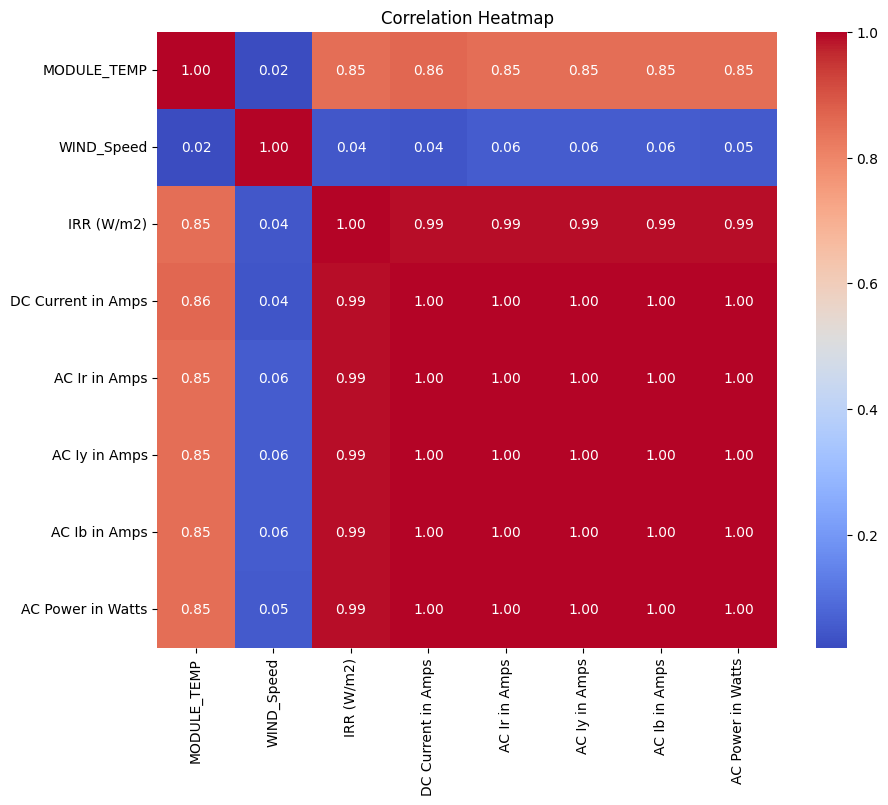

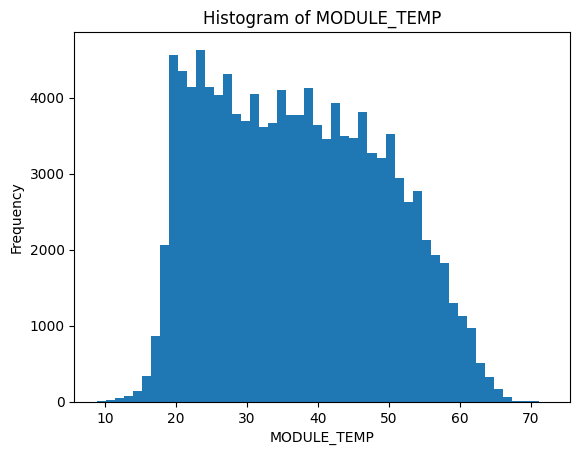

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

#read csv file
df = pd.read_csv("Karnataka_india_cleared.csv")

#print a graph AC Power in Watts over is IRR (W/m2)
'''print(df.columns)
plt.scatter(df['IRR (W/m2)'], df['AC Power in Watts'])
plt.xlabel('IRR (W/m2)') 
plt.ylabel('AC Power in Watts')
plt.title('AC Power vs IRR')
plt.show()

#histogram of AC Power in Watts and add boxplot on top of it
plt.hist(df['AC Power in Watts'], bins=50)
plt.xlabel('AC Power in Watts')
plt.ylabel('Frequency')
plt.title('Histogram of AC Power')
sns.boxplot(x=df['AC Power in Watts'], color='red', width=0.5)
plt.show()

#histogram of IRR (W/m2) and overlay a kde plot
plt.hist(df['IRR (W/m2)'], bins=50, alpha=0.5, color='blue')
sns.kdeplot(df['IRR (W/m2)'], color='red')
plt.xlabel('IRR (W/m2)')
plt.ylabel('Frequency')
plt.title('Histogram of IRR')
plt.show()

#divide the data into 2 csv file, one where IRR is greater than 150 and one where IRR is less than or equal to 150
df_high_irr = df[df[' IRR (W/m2) '] > 150]
df_low_irr = df[df[' IRR (W/m2) '] <= 150]
df_high_irr.to_csv("Karnataka_india_high_irr.csv", index=False)
df_low_irr.to_csv("Karnataka_india_low_irr.csv", index=False)

#graph MODULE_TEMP over WIND_Speed
plt.scatter(df['MODULE_TEMP'], df[' WIND_Speed '])
plt.xlabel('MODULE_TEMP')
plt.ylabel(' WIND_Speed ')
plt.title('WIND_Speed vs MODULE_TEMP')
plt.show()'''

# Select only numeric columns for correlation analysis
numeric_columns = df.select_dtypes(include=['number'])

# Compute the correlation matrix for numeric columns
correlation_matrix = numeric_columns.corr()

# Plot the correlation heatmap and Spearman correlation coefficients
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

#plot histogram of MODULE_TEMP
plt.hist(df['MODULE_TEMP'], bins=50)
plt.xlabel('MODULE_TEMP')
plt.ylabel('Frequency')
plt.title('Histogram of MODULE_TEMP')
plt.show()





India- clear- High (daytime)

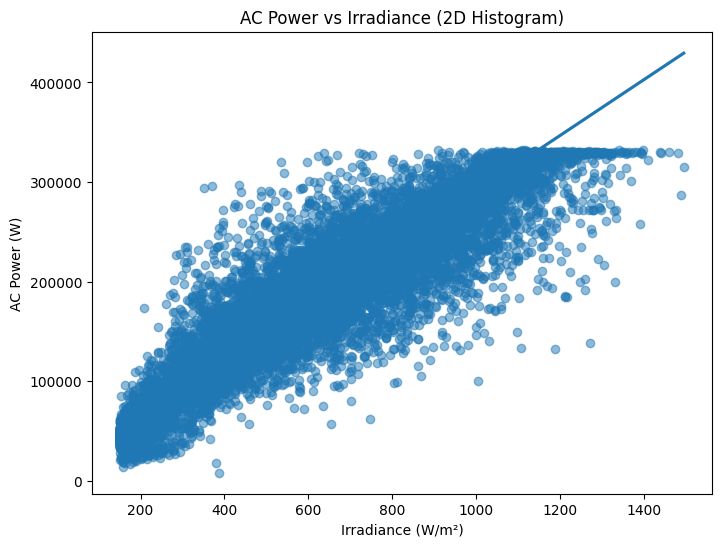

In [21]:
#read csv file "Karnataka_india_high_irr.csv"
import pandas as pd
df = pd.read_csv("Karnataka_india_high_irr.csv")    

#print a graph xaxis is  AC Power in Watts and yaxis is IRR (W/m2), add a regression line
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
sns.regplot(x=' IRR (W/m2)', y=' AC Power in Watts', data=df, scatter_kws={'alpha':0.5})
plt.xlabel('Irradiance (W/m²)')
plt.ylabel('AC Power (W)')
plt.title('AC Power vs Irradiance (2D Histogram)')
plt.show()


India- analysis for nighttime

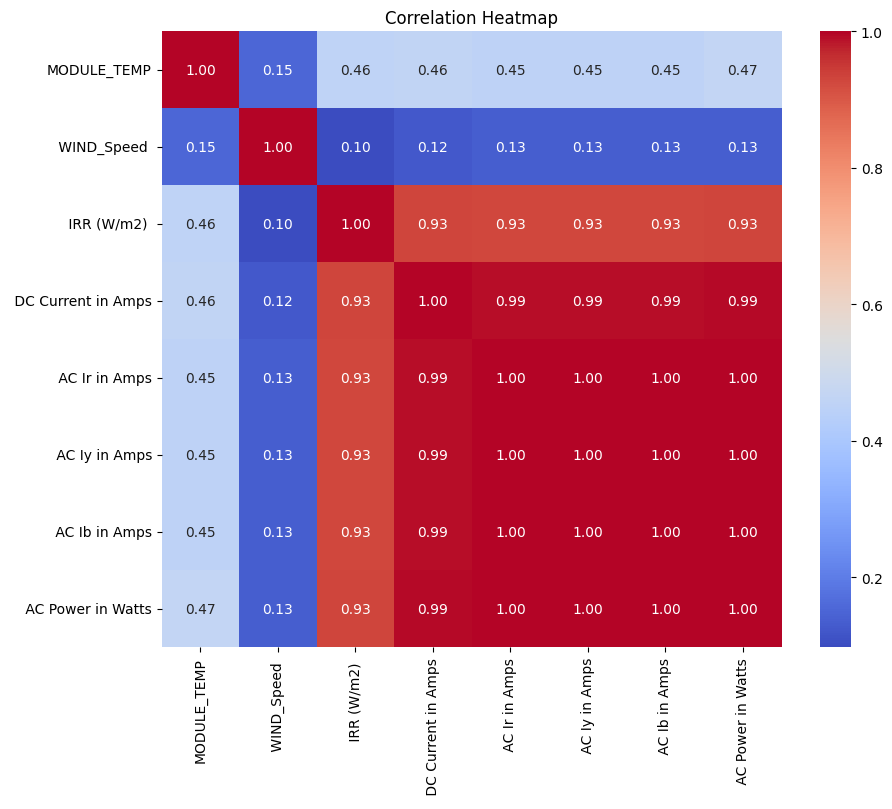

In [23]:
#read csv file 
import pandas as pd
df = pd.read_csv("Karnataka_india_low_irr.csv")

#Histogram of AC Power in Watts, Module_Temp and IRR (W/m2)
import matplotlib.pyplot as plt
'''plt.hist(df[' AC Power in Watts'], bins=50)
plt.xlabel(' AC Power in Watts ')
plt.ylabel('Frequency')
plt.title('Histogram of AC Power (Low IRR <= 150 W/m2)')
plt.show()

#Histogram of IRR (W/m2)
plt.hist(df[' IRR (W/m2) '], bins=50)
plt.xlabel(' IRR (W/m2) ')
plt.ylabel('Frequency')
plt.title('Histogram of IRR (Low IRR <= 150 W/m2)')
plt.show()

#Histogram of MODULE_TEMP
plt.hist(df['MODULE_TEMP'], bins=50)
plt.xlabel('MODULE_TEMP')
plt.ylabel('Frequency')
plt.title('Histogram of MODULE_TEMP (Low IRR <= 150 W/m2)')
plt.show()'''

# Select only numeric columns for correlation analysis
numeric_columns = df.select_dtypes(include=['number'])

# Compute the correlation matrix for numeric columns
correlation_matrix = numeric_columns.corr()

# Plot the correlation heatmap and Spearman correlation coefficients
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

India analysis for daytime

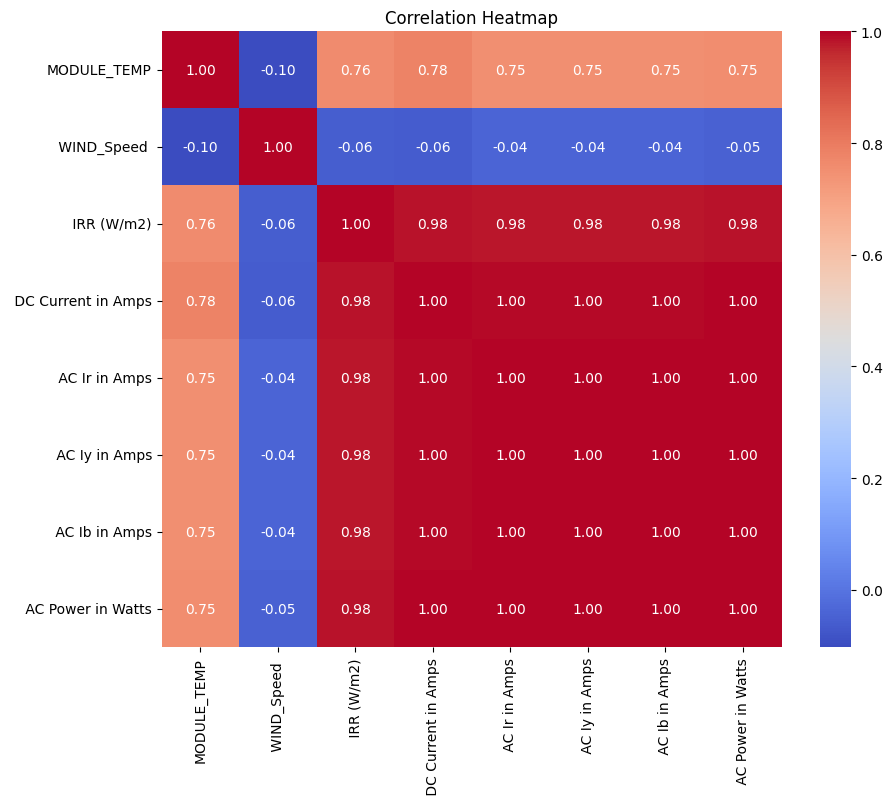

In [24]:
#read csv file 
import pandas as pd
df = pd.read_csv("Karnataka_india_high_irr.csv")

#Histogram of AC Power in Watts, Module_Temp and IRR (W/m2)
import matplotlib.pyplot as plt
'''plt.hist(df[' AC Power in Watts'], bins=50)
plt.xlabel(' AC Power in Watts ')
plt.ylabel('Frequency')
plt.title('Histogram of AC Power (High IRR > 150 W/m2)')
plt.show()

#Histogram of IRR (W/m2)
plt.hist(df[' IRR (W/m2) '], bins=50)
plt.xlabel(' IRR (W/m2) ')
plt.ylabel('Frequency')
plt.title('Histogram of IRR (High IRR > 150 W/m2)')
plt.show()

#Histogram of MODULE_TEMP
plt.hist(df['MODULE_TEMP'], bins=50)
plt.xlabel('MODULE_TEMP')
plt.ylabel('Frequency')
plt.title('Histogram of MODULE_TEMP (High IRR > 150 W/m2)')
plt.show()

#Pairplot of AC Power in Watts, Module_Temp and IRR (W/m2)
import seaborn as sns
sns.pairplot(df[[' AC Power in Watts', 'MODULE_TEMP', ' IRR (W/m2)']])
plt.suptitle('Pairplot of AC Power, MODULE_TEMP, and IRR (High IRR > 150 W/m2)', y=1.02)
plt.show()'''

# Select only numeric columns for correlation analysis
numeric_columns = df.select_dtypes(include=['number'])

# Compute the correlation matrix for numeric columns
correlation_matrix = numeric_columns.corr()

# Plot the correlation heatmap and Spearman correlation coefficients
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


Cleaning Denmark

In [22]:
#read csv file "Denmark_Kalundbor.csv" 
import pandas as pd
# read with semicolon separator and comma decimal (European format)
df = pd.read_csv("Denmark_Kalundbor.csv", sep=';', decimal=',', engine='python', encoding='utf-8')
# normalize column names
df.columns = df.columns.str.strip()

# rename columns to friendly names
df = df.rename(columns={
    'PCTimeStamp': 'Date and time',
    'WTG01_Ambient WindSpeed Avg. (1)': 'Wind_speed',
    'WTG01_Blades PitchAngle Avg. (2)': 'Blade_pitch_angle',
    'WTG01_Grid Production Power Avg. (3)': 'Power_output'
})

# parse datetime (day-first) and coerce malformed values to NaT
if 'Date and time' in df.columns:
    df['Date and time'] = pd.to_datetime(df['Date and time'].astype(str).str.strip(), dayfirst=True, errors='coerce')

# coerce numeric columns to floats (replace comma decimal if any remained)
for col in ['Wind_speed', 'Power_output']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col].astype(str).str.strip().str.replace(',', '.', regex=False), errors='coerce')

# drop Blade_pitch_angle column if present
df = df.drop(columns=['Blade_pitch_angle'], errors='ignore')
print(df.columns)

# drop rows missing essential data (datetime, wind or power)
df = df.dropna(subset=[c for c in ['Date and time', 'Wind_speed', 'Power_output'] if c in df.columns], how='any')
print(df.info())
print(df.describe())

# save the cleaned file
df.to_csv("Denmark_Kalundborg_cleared.csv", sep=';', index=False)



Index(['Date and time', 'Wind_speed', 'Power_output'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 1726 entries, 0 to 250560
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date and time  1726 non-null   datetime64[ns]
 1   Wind_speed     1726 non-null   float64       
 2   Power_output   1726 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 53.9 KB
None
                       Date and time   Wind_speed  Power_output
count                           1726  1726.000000   1726.000000
mean   2022-04-15 03:37:45.121668608     6.176999    628.557358
min              2019-12-01 00:00:00     0.100000    -24.400000
25%              2021-02-05 06:00:00     4.400000    135.775000
50%              2022-04-12 12:00:00     5.800000    418.650000
75%              2023-06-21 18:00:00     7.600000    983.125000
max              2024-09-05 00:00:00    20.900000   2003.7

Denmark analysis

Index(['Date and time', 'Wind_speed', 'Power_output'], dtype='object')


Index(['Date and time', 'Wind_speed', 'Power_output'], dtype='object')


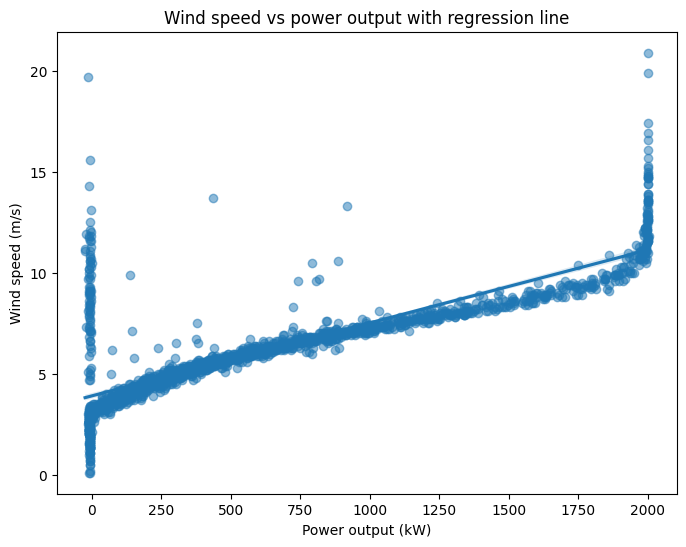

In [29]:
#read csv file "Denmark_Kalundborg_cleared.csv"
import pandas as pd
df = pd.read_csv("Denmark_Kalundborg_cleared.csv", sep=';', decimal=',', engine='python', encoding='utf-8')
print(df.columns)
'''
#print histogram of Wind_speed
import matplotlib.pyplot as plt
plt.hist(df['Wind_speed'], bins=50)
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Frequency')
plt.title('Histogram of wind speed')
plt.show()

#scatter plot of Wind_speed vs Power_output
plt.scatter(df['Wind_speed'], df['Power_output'], alpha=0.5)
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Power output (kW)')
plt.title('Power output vs Wind speed')
plt.show()

#histogram of Power_output
plt.hist(df['Power_output'], bins=50)
plt.xlabel('Power output (kW)')
plt.ylabel('Frequency')
plt.title('Histogram of power output')
plt.show()


#correlation heatmap between Wind_speed and Power_output
import seaborn as sns
correlation_matrix = df[['Wind_speed', 'Power_output']].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation heatmap between Wind speed and Power output')
plt.show()'''

#print a graph xaxis is Power_output and yaxis is wind_speed
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
sns.regplot(x='Power_output', y='Wind_speed', data=df, scatter_kws={'alpha':0.5})
plt.xlabel('Power output (kW)')
plt.ylabel('Wind speed (m/s)')
plt.title('Wind speed vs power output with regression line')
plt.show()




Clean Turkey

In [38]:
#read a csv file "Yalova Tureky.csv"
import pandas as pd
df = pd.read_csv("Yalova Tureky.csv")

#delete column: 'Wind Direction (°)
df = df.drop(columns=['Wind Direction (°)'], errors='ignore')

#change the columns names: 'Date & Time' to 'Date_and_time', Wind Speed (m/s)' to 'Wind_speed', Theoretical_Power_Curve (KWh)' to 'Theoretical_Power'
df = df.rename(columns={
    'Date & Time': 'Date_and_time',
    'Wind Speed (m/s)': 'Wind_speed',
    'LV ActivePower (kW)': 'Active_Power',
    'Theoretical_Power_Curve (KWh)': 'Theoretical_Power'
})  
print(df.columns)

#delete nan values from the dataframe
df = df.dropna()
print(df.info())
print(df.describe())

#save the file as "Yalova_Turkey_cleared.csv"
df.to_csv("Yalova_Turkey_cleared.csv", index=False)



Index(['Date/Time', 'Active_Power', 'Wind_speed', 'Theoretical_Power'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date/Time          50530 non-null  object 
 1   Active_Power       50530 non-null  float64
 2   Wind_speed         50530 non-null  float64
 3   Theoretical_Power  50530 non-null  float64
dtypes: float64(3), object(1)
memory usage: 1.5+ MB
None
       Active_Power    Wind_speed  Theoretical_Power
count  50530.000000  50530.000000       50530.000000
mean    1307.684332      7.557952        1492.175463
std     1312.459242      4.227166        1368.018238
min       -2.471405      0.000000           0.000000
25%       50.677890      4.201395         161.328167
50%      825.838074      7.104594        1063.776283
75%     2482.507568     10.300020        2964.972462
max     3618.732910     25.206011  

Analysis for the Turkey

Columns: ['Date/Time', 'Active_Power', 'Wind_speed', 'Theoretical_Power']


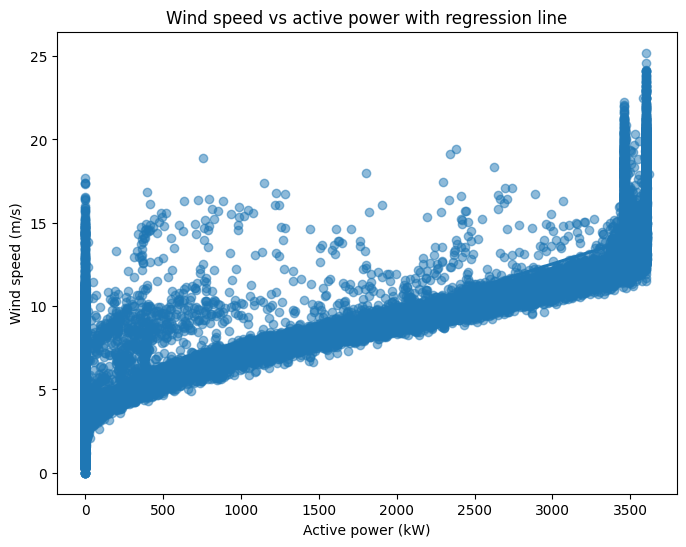

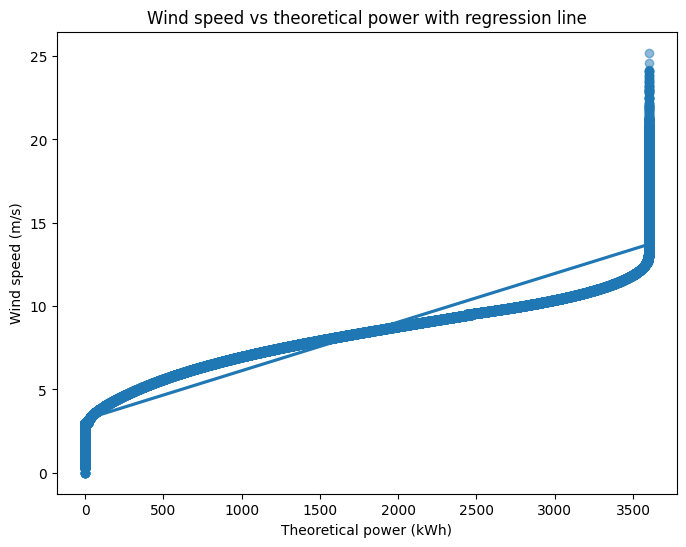

In [44]:
#read csv file "Yalova_Turkey_cleared.csv"
import pandas as pd

# read CSV and strip spaces after delimiters so column names are clean
df = pd.read_csv("Yalova_Turkey_cleared.csv", skipinitialspace=True)
df.columns = df.columns.str.strip()

# quick check of column names
print('Columns:', df.columns.tolist())
'''
#Histogram of Wind_speed 
import matplotlib.pyplot as plt
plt.hist(df['Wind_speed'], bins=50)
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Frequency')
plt.title('Histogram of wind speed')
plt.show()

#histogram of  Active_Power
plt.hist(df['Active_Power'], bins=50)
plt.xlabel('Active power (kW)')
plt.ylabel('Frequency')
plt.title('Histogram of active power')
plt.show()

#historgram of Theoretical_Power
plt.hist(df['Theoretical_Power'], bins=50)
plt.xlabel('Theoretical power (kWh)')
plt.ylabel('Frequency')
plt.title('Histogram of theoretical power')
plt.show()

#correlation heatmap between Wind_speed, Active_Power and Theoretical_Power
import seaborn as sns
correlation_matrix = df[['Wind_speed', 'Active_Power', 'Theoretical_Power']].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation heatmap between wind speed, active power and theoretical power')
plt.show()'''

#print a graph xaxis is Active_Power and yaxis is Wind_speed
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
sns.regplot(x='Active_Power', y='Wind_speed', data=df, scatter_kws={'alpha':0.5})
plt.xlabel('Active power (kW)')
plt.ylabel('Wind speed (m/s)')
plt.title('Wind speed vs active power with regression line')
plt.show()

#print a graph xaxis is Theoretical_Power and yaxis is Wind_speed
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
sns.regplot(x='Theoretical_Power', y='Wind_speed', data=df, scatter_kws={'alpha':0.5})
plt.xlabel('Theoretical power (kWh)')
plt.ylabel('Wind speed (m/s)')
plt.title('Wind speed vs theoretical power with regression line')
plt.show()
